In [1]:
import argparse
import numpy as np
# 使用数据科学常用的库的scipy中的高斯分布
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
# 可视化库
import seaborn as sns

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 对抗生成网络总共有两个模型
#### D模型
  有两个输入，一个是G网络的输出，G网络的输出就是我们生成的数据，另一个输入就是一个真实的输入，我们的D模型要判断出，这两个输入是否是一个真实的输入，要进行预训练。
#### G模型
  生成模型，输一个噪音，没有任何的规则，最终生成的数据和真实数据越接近越好。

In [2]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range
    
    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01

In [4]:
class DataDistribution(object):
    def __init__(self):
        self.mu = 4
        self.sigma = 0.5
    
    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

In [5]:
class GAN(object):
    def __init__(self, data, gen, num_steps, batch_size, log_every):
        self.data = data
        self.gen = gen
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.mip_hidden_size = 4
        
        self.learning_rate = 0.03
        self._create_model()
        
    def _create_model(self):
        with tf.variable_scope("D_pre"):
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            
            D_pre = self.discriminator(self.pre_input, self.mip_hidden_size)
            self.pre_loss = tf.reduce_mean(tf.square(D_pre - self.pre_labels))
            self.pre_opt = self.optimizer(self.pre_loss, None, self.learning_rate)
        
        with tf.variable_scope("Gen"):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = self.generator(self.z, self.mip_hidden_size)
        
        with tf.variable_scope("Disc") as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D1 = self.discriminator(self.x, self.mip_hidden_size)
            scope.reuse_variables()
            self.D2 = self.discriminator(self.G, self.mip_hidden_size)
        
        self.loss_d = tf.reduce_mean(-tf.log(self.D1) - tf.log(1-self.D2))
        self.loss_g = tf.reduce_mean(-tf.log(self.D2))
        
        self.d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="D_pre")
        self.d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="Disc")
        self.g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="Gen")
        
        self.opt_d = self.optimizer(self.loss_d, self.d_params, self.learning_rate)
        self.opt_g = self.optimizer(self.loss_g, self.g_params, self.learning_rate)
        
    def discriminator(self, input, h_dim):
        h0 = tf.tanh(self.linear(input, h_dim * 2, "d0"))
        h1 = tf.tanh(self.linear(h0, h_dim * 2, "d1"))
        h2 = tf.tanh(self.linear(h1, h_dim * 2, scope="d2"))
        
        h3 = tf.sigmoid(self.linear(h1, 1, scope="d3"))
        
        return h3
        
    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            
            num_pretrain_steps = 1000
            # 用于D_pre的预训练
            for step in range(num_pretrain_steps):
                # 生成d的数据
                d = (np.random.random(self.batch_size) - 0.5) * 10.0
                # 生成数据的label
                labels = norm.pdf(d, loc=self.data.mu, scale=self.data.sigma)
                reshape_labels = np.reshape(labels, (self.batch_size, 1))
                pretrain_loss,_ = session.run([self.pre_loss, self.pre_opt],
                                          {self.pre_input:np.reshape(d, (self.batch_size, 1)),
                                           self.pre_labels:reshape_labels,
                                          })
                # 获取到D_pre的训练好的参数，并将Dist的网络参数替换成预训练的参数
            self.weightsD = session.run(self.d_pre_params)
            for i, v in enumerate(self.d_params):
                session.run(v.assign(self.weightsD[i]))
                
            for step in range(self.num_steps):
                # x是构建的真实的数据
                x = self.data.sample(self.batch_size)
                # z是随意构建的噪音数据
                z = self.gen.sample(self.batch_size)
                loss_d,_ = session.run([self.loss_d, self.opt_d], {
                    self.x:np.reshape(x, (self.batch_size, 1)),
                    self.z:np.reshape(z, (self.batch_size, 1))
                })
                z = self.gen.sample(self.batch_size)
                loss_g, _ = session.run([self.loss_g, self.opt_g], {
                    self.z:np.reshape(z, (self.batch_size, 1))
                })
                    
                if step % self.log_every == 0:
                    print("{}:{}\t{}".format(step, loss_d, loss_g))
                if step % 100 == 0 or step==0 or step == self.num_steps-1:
                    self._plot_distributions(session)
                    
    def _plot_distributions(self, session):
        x = self.data.sample(self.batch_size)
        z = self.gen.sample(self.batch_size)
        
        gen = session.run(self.G, {self.z:np.reshape(z, (self.batch_size, 1))})
        plt.plot(x, 'r')
        plt.plot(gen, 'b')
        plt.show()
    
    def linear(self, input, output_dims, scope=None, stddev=1.0):
        norm = tf.random_normal_initializer(stddev=stddev)
        const = tf.constant_initializer(0.0)
        with tf.variable_scope(scope or 'linear'):
            w = tf.get_variable('w', [input.get_shape()[1], output_dims], initializer=norm)
            b = tf.get_variable('b', [output_dims], initializer=const)
            return tf.matmul(input, w) + b
    
    def optimizer(self, loss, var_list, learning_rate):
        # 使用学习率衰减策略
        decay = 0.95
        num_decay_steps = 150
        batch = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(
            learning_rate,
            batch,
            num_decay_steps,
            decay,
            staircase=True
        )
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=batch, var_list=var_list)
        return optimizer
    
    def generator(self, input, h_dim):
        h0 = tf.nn.softplus(self.linear(input, h_dim, 'g0'))
        h1 = self.linear(h0, 1, "g1")
        return h1

In [6]:
def main():
    model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=0),1200,16,10
    )
    model.train()

0:0.7319703698158264	3.7105093002319336


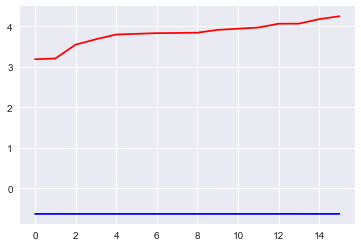

10:0.061796244233846664	3.2911763191223145
20:0.05232923477888107	3.4399261474609375
30:0.04595176875591278	3.5719659328460693
40:0.04284239560365677	3.68872332572937
50:0.037268850952386856	3.794332981109619
60:0.03391823172569275	3.8918185234069824
70:0.03522590547800064	3.979694366455078
80:0.028729647397994995	4.062256336212158
90:0.02695319801568985	4.139100074768066
100:0.02468555048108101	4.210970878601074


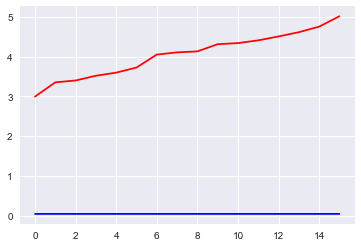

110:0.023116720840334892	4.278170585632324
120:0.02266096882522106	4.341248035430908
130:0.021197263151407242	4.4008564949035645
140:0.020305555313825607	4.457550048828125
150:0.019210543483495712	4.510723114013672
160:0.018603485077619553	4.55856990814209
170:0.01764097809791565	4.600048065185547
180:0.4944611191749573	4.04250431060791
190:4.976042747497559	0.010377388447523117
200:1.332791805267334	0.6614190340042114


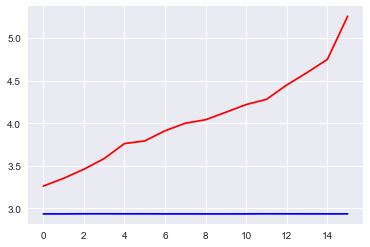

210:1.0801504850387573	0.879830002784729
220:1.5038344860076904	0.7318137288093567
230:1.4582949876785278	0.693522572517395
240:1.408156394958496	0.6797903776168823
250:1.4054808616638184	0.6799781322479248
260:1.3921005725860596	0.6824936866760254
270:1.3925734758377075	0.6847043037414551
280:1.3948627710342407	0.6857391595840454
290:1.3908803462982178	0.6865243911743164
300:1.3892121315002441	0.6871391534805298


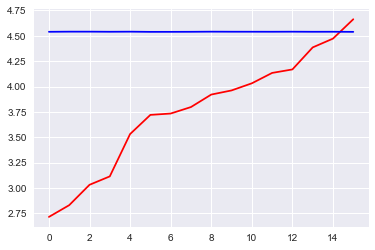

310:1.3873597383499146	0.6881973743438721
320:1.3878530263900757	0.6886245012283325
330:1.385904312133789	0.6893912553787231
340:1.385148048400879	0.6892654299736023
350:1.384642243385315	0.6892918348312378
360:1.3840080499649048	0.6896144151687622
370:1.382780909538269	0.689456582069397
380:1.3821805715560913	0.6895966529846191
390:1.3782700300216675	0.6892235279083252
400:1.3796595335006714	0.688918948173523


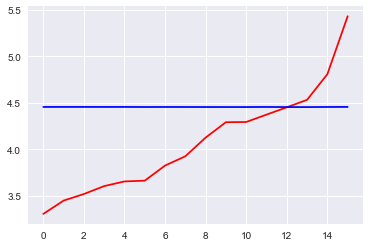

410:1.3797078132629395	0.6892609596252441
420:1.3728621006011963	0.6877789497375488
430:1.372798204421997	0.6877390146255493
440:1.36899733543396	0.6870100498199463
450:1.3698879480361938	0.686935544013977
460:1.3735644817352295	0.6872928142547607
470:1.3634440898895264	0.686781108379364
480:1.3671355247497559	0.6897134780883789
490:1.3743960857391357	0.6924833655357361
500:1.379923701286316	0.6972667574882507


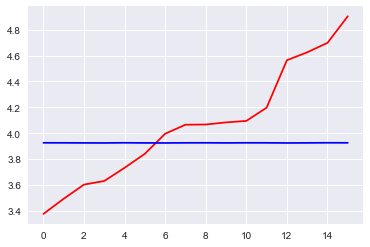

510:1.3954354524612427	0.6969655156135559
520:1.4010785818099976	0.7048224806785583
530:1.409799575805664	0.708734393119812
540:1.3993122577667236	0.7099722027778625
550:1.3950260877609253	0.7092363834381104
560:1.3919858932495117	0.7092998027801514
570:1.3832323551177979	0.7029471397399902
580:1.3790253400802612	0.698125958442688
590:1.3771438598632812	0.6954784393310547
600:1.372352123260498	0.6947482824325562


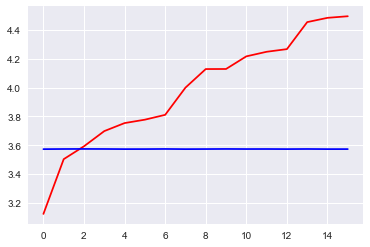

610:1.371086597442627	0.6944786310195923
620:1.3728607892990112	0.6945897936820984
630:1.367988109588623	0.6953023672103882
640:1.3730440139770508	0.6951907873153687
650:1.374365210533142	0.6954585909843445
660:1.3716857433319092	0.6954042911529541
670:1.371619462966919	0.695496678352356
680:1.382261872291565	0.6949257850646973
690:1.3860609531402588	0.6951855421066284
700:1.3803446292877197	0.6949254870414734


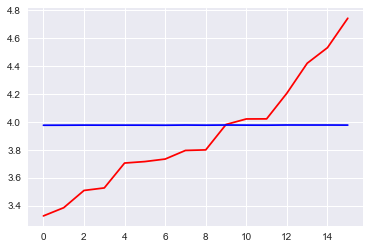

710:1.3745311498641968	0.6952613592147827
720:1.3874565362930298	0.6955718398094177
730:1.3903348445892334	0.6966838836669922
740:1.3879722356796265	0.6968177556991577
750:1.3888201713562012	0.6969799995422363
760:1.3860875368118286	0.6990668773651123
770:1.3846495151519775	0.6980314254760742
780:1.383491039276123	0.695693850517273
790:1.37901771068573	0.69011390209198
800:1.3822276592254639	0.6852265000343323


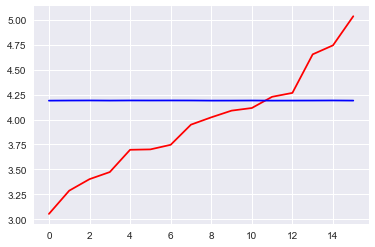

810:1.3805820941925049	0.6855658292770386
820:1.3794288635253906	0.6830586791038513
830:1.38531494140625	0.6865247488021851
840:1.3726587295532227	0.6855196952819824
850:1.3794670104980469	0.6910268664360046
860:1.3710023164749146	0.7004451751708984
870:1.3881072998046875	0.7058834433555603
880:1.394316554069519	0.7145786285400391
890:1.3822576999664307	0.7066217660903931
900:1.381493091583252	0.6991336941719055


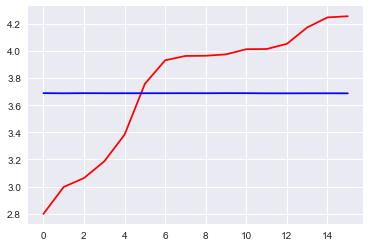

910:1.3790998458862305	0.694663405418396
920:1.3774549961090088	0.6933562755584717
930:1.3817930221557617	0.6930437088012695
940:1.376237154006958	0.6938269138336182
950:1.3751332759857178	0.6949562430381775
960:1.3825244903564453	0.6947567462921143
970:1.3823766708374023	0.6958873271942139
980:1.3866591453552246	0.6968866586685181
990:1.382110834121704	0.6968059539794922
1000:1.3793379068374634	0.697687566280365


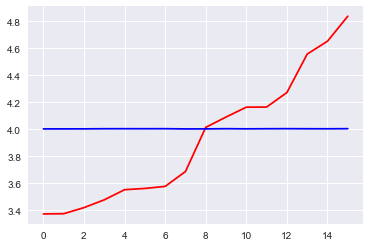

1010:1.375946044921875	0.6965279579162598
1020:1.381211519241333	0.696416437625885
1030:1.3831771612167358	0.6989355087280273
1040:1.3825044631958008	0.696992039680481
1050:1.3782297372817993	0.6946901082992554
1060:1.3738876581192017	0.6921451091766357
1070:1.371255874633789	0.6839767694473267
1080:1.3928269147872925	0.689255952835083
1090:1.3849244117736816	0.6918871402740479
1100:1.3895854949951172	0.6961132287979126


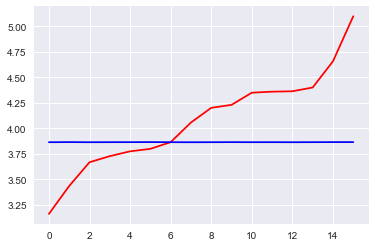

1110:1.3860055208206177	0.7012122869491577
1120:1.3846896886825562	0.6990768313407898
1130:1.382652997970581	0.6961066722869873
1140:1.3788013458251953	0.6947493553161621
1150:1.3726129531860352	0.6936436891555786
1160:1.383558988571167	0.6956210136413574
1170:1.379934310913086	0.6959489583969116
1180:1.3838412761688232	0.6974817514419556
1190:1.3770599365234375	0.697856068611145
1200:1.3830857276916504	0.6979018449783325


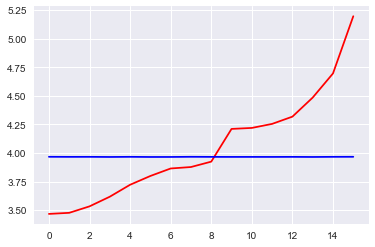

1210:1.3803434371948242	0.6975436210632324
1220:1.3781836032867432	0.6979354023933411
1230:1.3698798418045044	0.6993287801742554
1240:1.377212643623352	0.6957547068595886
1250:1.3640681505203247	0.6942542791366577
1260:1.3771626949310303	0.6920037269592285
1270:1.3699665069580078	0.6932626366615295
1280:1.3797028064727783	0.6953657865524292
1290:1.3802326917648315	0.6956263184547424
1300:1.3799604177474976	0.694696307182312


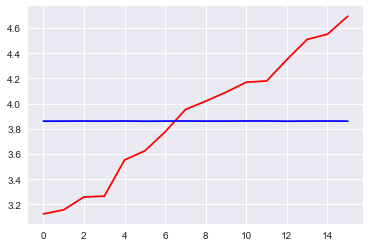

1310:1.3739875555038452	0.6952598094940186
1320:1.3766753673553467	0.6963189244270325
1330:1.371444582939148	0.6945933103561401
1340:1.3772225379943848	0.6991410851478577
1350:1.3796420097351074	0.6977732181549072
1360:1.3763225078582764	0.696752667427063
1370:1.379599928855896	0.6976717710494995
1380:1.3726897239685059	0.6978552937507629
1390:1.3757908344268799	0.696227490901947
1400:1.3695403337478638	0.6957252621650696


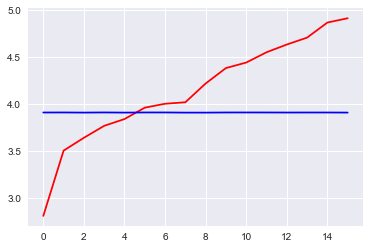

1410:1.3756718635559082	0.6959371566772461
1420:1.3648946285247803	0.697270393371582
1430:1.3710384368896484	0.6966917514801025
1440:1.3686721324920654	0.6974133253097534
1450:1.375257134437561	0.6981703042984009
1460:1.3838790655136108	0.696552574634552
1470:1.374582290649414	0.7013862133026123
1480:1.3662357330322266	0.7027385234832764
1490:1.375380277633667	0.6990305185317993
1500:1.3632957935333252	0.6970654726028442


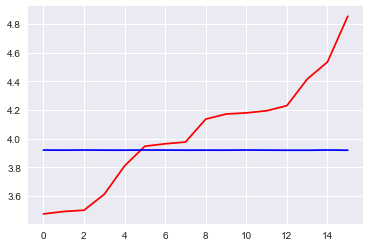

1510:1.3666493892669678	0.69767165184021
1520:1.3660883903503418	0.6976779103279114
1530:1.3595904111862183	0.6980795860290527
1540:1.361879825592041	0.7008135318756104
1550:1.3693119287490845	0.6997297406196594
1560:1.3766093254089355	0.6990103721618652
1570:1.36775803565979	0.7001951932907104
1580:1.3628990650177002	0.7013062238693237
1590:1.3753747940063477	0.6994413733482361
1600:1.3764379024505615	0.6987914443016052


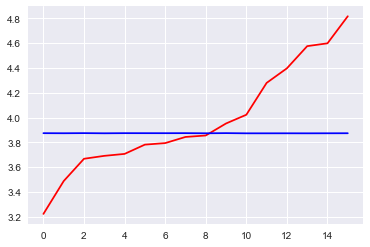

1610:1.3639968633651733	0.702540397644043
1620:1.3658835887908936	0.7051703929901123
1630:1.3619437217712402	0.7049657702445984
1640:1.3622320890426636	0.6990868449211121
1650:1.3728325366973877	0.699394702911377
1660:1.3679661750793457	0.6993333101272583
1670:1.3618561029434204	0.7016735076904297
1680:1.358776569366455	0.7049188613891602
1690:1.3617998361587524	0.7083813548088074
1700:1.3653451204299927	0.70285564661026


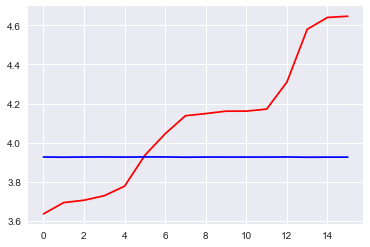

1710:1.3706135749816895	0.6997479200363159
1720:1.3791636228561401	0.7007114291191101
1730:1.359449028968811	0.7044274210929871
1740:1.3613895177841187	0.7044772505760193
1750:1.3568575382232666	0.7065128087997437
1760:1.3682916164398193	0.6976708769798279
1770:1.3707971572875977	0.7010459899902344
1780:1.3599681854248047	0.7098102569580078
1790:1.35426926612854	0.7029614448547363
1800:1.3538520336151123	0.704147458076477


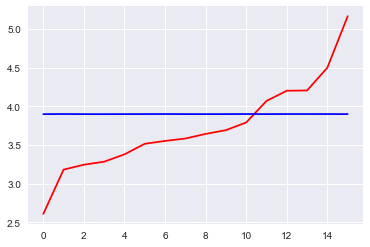

1810:1.377507209777832	0.7038570642471313
1820:1.3509085178375244	0.7050014734268188
1830:1.3600165843963623	0.7052693367004395
1840:1.3594837188720703	0.7047816514968872
1850:1.365166187286377	0.7014526128768921
1860:1.3594746589660645	0.7015011310577393
1870:1.354783058166504	0.7172185182571411
1880:1.3552762269973755	0.7104073762893677
1890:1.3603466749191284	0.7073452472686768
1900:1.3550000190734863	0.7038852572441101


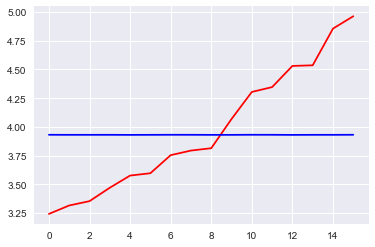

1910:1.3597826957702637	0.703361451625824
1920:1.3634270429611206	0.7020048499107361
1930:1.3645002841949463	0.7021925449371338
1940:1.3509128093719482	0.7139497995376587
1950:1.3437728881835938	0.7092205286026001
1960:1.37442946434021	0.7072829008102417
1970:1.36907958984375	0.7004829049110413
1980:1.3719069957733154	0.7107837200164795
1990:1.352713942527771	0.7096450328826904
2000:1.3480479717254639	0.7087761163711548


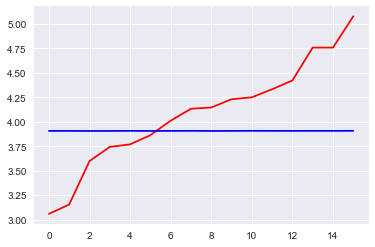

2010:1.3594459295272827	0.7069070935249329
2020:1.3631196022033691	0.7068073153495789
2030:1.3625824451446533	0.7201299667358398
2040:1.3492716550827026	0.7056779861450195
2050:1.352515459060669	0.7030069828033447
2060:1.3478342294692993	0.7139114737510681
2070:1.3581819534301758	0.715311586856842
2080:1.3495224714279175	0.7075496912002563
2090:1.367539644241333	0.7100719213485718
2100:1.3472058773040771	0.7001476883888245


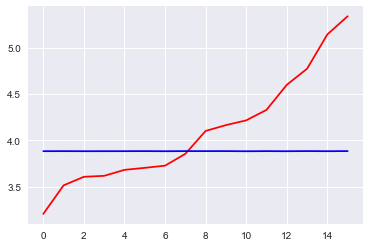

2110:1.3328990936279297	0.718480110168457
2120:1.3410465717315674	0.7188947200775146
2130:1.3650988340377808	0.7057563066482544
2140:1.3266401290893555	0.7186715602874756
2150:1.3368494510650635	0.7115691304206848
2160:1.3521552085876465	0.7053235173225403
2170:1.3515839576721191	0.7125872373580933
2180:1.360065221786499	0.7154586911201477
2190:1.3257559537887573	0.7161334753036499
2200:1.3589701652526855	0.7157527208328247


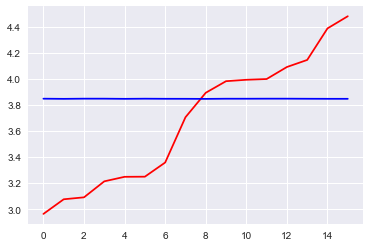

2210:1.3460404872894287	0.70558762550354
2220:1.3448021411895752	0.7140061855316162
2230:1.3343777656555176	0.7291495203971863
2240:1.3618087768554688	0.7031013369560242
2250:1.3401144742965698	0.7143465876579285
2260:1.3588566780090332	0.7163718938827515
2270:1.3447574377059937	0.7131912708282471
2280:1.3487517833709717	0.7192959785461426
2290:1.3490512371063232	0.7192936539649963
2300:1.3375465869903564	0.7228002548217773


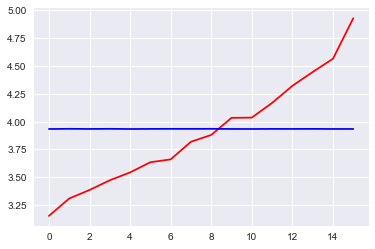

2310:1.314561367034912	0.7176017761230469
2320:1.3412835597991943	0.7204016447067261
2330:1.354536533355713	0.7135915756225586
2340:1.3309125900268555	0.7157725095748901
2350:1.3324919939041138	0.7244760990142822
2360:1.3056182861328125	0.7230402231216431
2370:1.3317840099334717	0.7126424908638
2380:1.3534157276153564	0.7277358770370483
2390:1.3180632591247559	0.7141056060791016
2400:1.3731967210769653	0.7205738425254822


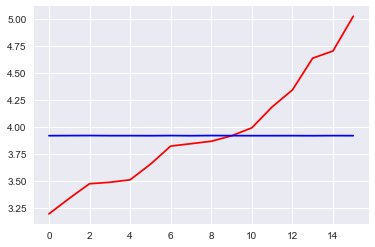

2410:1.3248631954193115	0.7244652509689331
2420:1.320846676826477	0.7244049310684204
2430:1.3288781642913818	0.7267285585403442
2440:1.3104327917099	0.721764862537384
2450:1.2965831756591797	0.7411231398582458
2460:1.3338314294815063	0.725943922996521
2470:1.329186201095581	0.7274665832519531
2480:1.3346214294433594	0.7277629971504211
2490:1.304795742034912	0.7430213093757629
2500:1.3331966400146484	0.7373032569885254


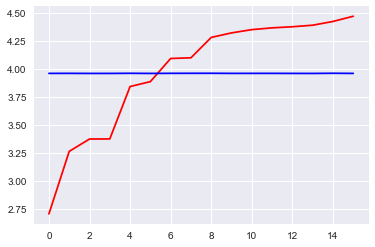

2510:1.2898799180984497	0.7395738363265991
2520:1.3054769039154053	0.7011930346488953
2530:1.3249937295913696	0.7302973866462708
2540:1.2782909870147705	0.7074887752532959
2550:1.3371230363845825	0.7401055097579956
2560:1.3544803857803345	0.7206229567527771
2570:1.2912273406982422	0.7413070797920227
2580:1.334031105041504	0.736354649066925
2590:1.2900288105010986	0.7362881898880005
2600:1.3250731229782104	0.7460265159606934


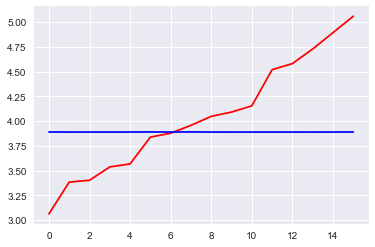

2610:1.347663164138794	0.7216441631317139
2620:1.3206124305725098	0.7307708859443665
2630:1.2790827751159668	0.746508002281189
2640:1.3290770053863525	0.7255712151527405
2650:1.277578592300415	0.724467933177948
2660:1.2654389142990112	0.7350629568099976
2670:1.318638801574707	0.7403412461280823
2680:1.3253730535507202	0.722031831741333
2690:1.2968578338623047	0.7473865151405334
2700:1.289147138595581	0.7365832328796387


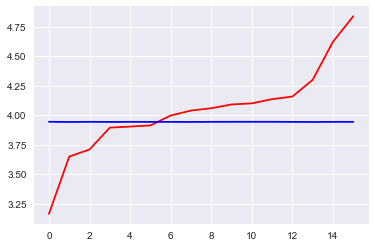

2710:1.2815698385238647	0.7489256858825684
2720:1.3022812604904175	0.734025776386261
2730:1.2930973768234253	0.7401884198188782
2740:1.3499629497528076	0.7248122692108154
2750:1.2985825538635254	0.76399827003479
2760:1.2697980403900146	0.7454031705856323
2770:1.269970417022705	0.7613588571548462
2780:1.3184864521026611	0.7570870518684387
2790:1.2860116958618164	0.7551866769790649
2800:1.2853443622589111	0.7366335391998291


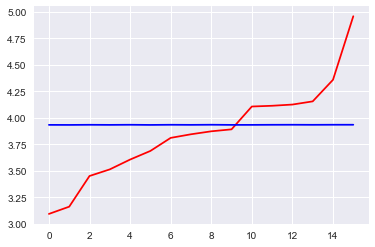

2810:1.3169149160385132	0.7448097467422485
2820:1.3131554126739502	0.7423616647720337
2830:1.2552013397216797	0.7542001008987427
2840:1.2748308181762695	0.7513375282287598
2850:1.2283928394317627	0.7568080425262451
2860:1.272885799407959	0.7490404844284058
2870:1.2564586400985718	0.7563700675964355
2880:1.307185173034668	0.7460248470306396
2890:1.260338544845581	0.763664960861206
2900:1.2958911657333374	0.7525135278701782


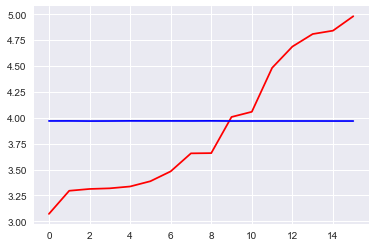

2910:1.3366267681121826	0.7489610910415649
2920:1.2782349586486816	0.7452512383460999
2930:1.212944746017456	0.769771933555603
2940:1.3201621770858765	0.7723565697669983
2950:1.288057804107666	0.7500379681587219
2960:1.259751796722412	0.7537917494773865
2970:1.3008681535720825	0.773750364780426
2980:1.2110800743103027	0.7823706865310669
2990:1.2470173835754395	0.7468657493591309
3000:1.2313151359558105	0.7731747627258301


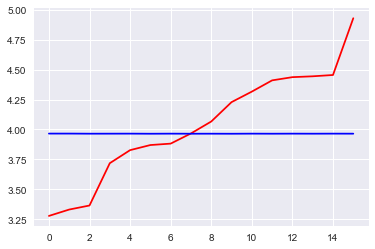

3010:1.2669020891189575	0.7632392048835754
3020:1.2514241933822632	0.766860842704773
3030:1.2442067861557007	0.7977529764175415
3040:1.2854481935501099	0.7467004060745239
3050:1.2911336421966553	0.7733732461929321
3060:1.2606735229492188	0.7777283191680908
3070:1.2068910598754883	0.7847177982330322
3080:1.2367475032806396	0.7993485927581787
3090:1.265388011932373	0.7771073579788208
3100:1.2334673404693604	0.781695544719696


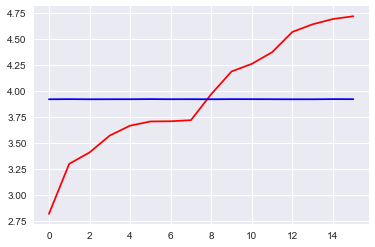

3110:1.3360154628753662	0.7565287947654724
3120:1.282539963722229	0.7048721313476562
3130:1.3412901163101196	0.7824684977531433
3140:1.2818760871887207	0.7468577027320862
3150:1.1929421424865723	0.7697169780731201
3160:1.2284066677093506	0.7807881832122803
3170:1.1599102020263672	0.7906949520111084
3180:1.1905410289764404	0.7707581520080566
3190:1.2452521324157715	0.7632047533988953
3200:1.21229088306427	0.8013508915901184


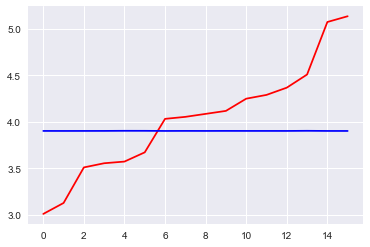

3210:1.1825369596481323	0.7919619083404541
3220:1.2010785341262817	0.7988276481628418
3230:1.2854335308074951	0.7844908833503723
3240:1.278003215789795	0.7786560654640198
3250:1.1234550476074219	0.8181161880493164
3260:1.298690915107727	0.8191204071044922
3270:1.2542977333068848	0.7844514846801758
3280:1.2427674531936646	0.7566595077514648
3290:1.293842077255249	0.7896082997322083
3300:1.2468888759613037	0.7919442653656006


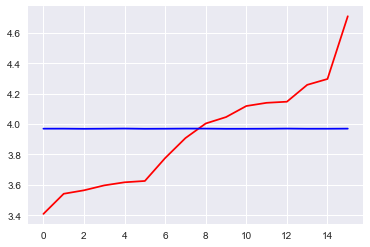

3310:1.220116138458252	0.7737247347831726
3320:1.2042701244354248	0.7941297292709351
3330:1.1133761405944824	0.8407270908355713
3340:1.270735502243042	0.811556339263916
3350:1.1370596885681152	0.7893582582473755
3360:1.1487139463424683	0.8306182026863098
3370:1.1627957820892334	0.8190645575523376
3380:1.2798078060150146	0.7547552585601807
3390:1.2178939580917358	0.8341957330703735
3400:1.2090154886245728	0.7992223501205444


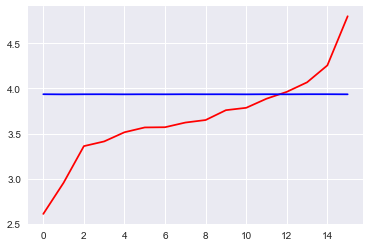

3410:1.1710474491119385	0.8418842554092407
3420:1.2423392534255981	0.8310229778289795
3430:1.091306209564209	0.8120646476745605
3440:1.1205954551696777	0.8103716373443604
3450:1.1370275020599365	0.8090127110481262
3460:1.143230676651001	0.8204948306083679
3470:1.2144529819488525	0.8063492774963379
3480:1.2111752033233643	0.8454198837280273
3490:1.106598138809204	0.8431689739227295
3500:1.2598323822021484	0.7821834087371826


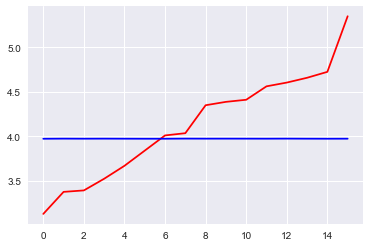

3510:1.1517010927200317	0.8488932847976685
3520:1.2317132949829102	0.8019428849220276
3530:1.1463623046875	0.81504225730896
3540:1.091381311416626	0.8533438444137573
3550:1.204184889793396	0.8177134990692139
3560:1.2582345008850098	0.8343149423599243
3570:1.2227201461791992	0.8222836256027222
3580:1.215601921081543	0.8282666206359863
3590:1.140028476715088	0.8167778849601746
3600:1.1993095874786377	0.8129752278327942


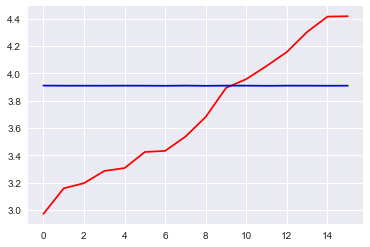

3610:1.2242954969406128	0.7805141806602478
3620:1.1787083148956299	0.8379867076873779
3630:1.1393582820892334	0.8861751556396484
3640:1.1378350257873535	0.8359394073486328
3650:1.2515050172805786	0.8601896166801453
3660:1.1818426847457886	0.8114113807678223
3670:1.1781561374664307	0.8551210761070251
3680:1.1461750268936157	0.8307626843452454
3690:1.0167227983474731	0.8953030109405518
3700:1.1457161903381348	0.8861972093582153


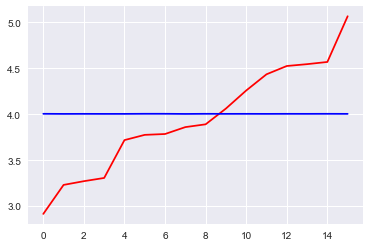

3710:1.0347487926483154	0.9106382727622986
3720:1.2088162899017334	0.8352080583572388
3730:1.129298210144043	0.8463871479034424
3740:1.113119125366211	0.8705924153327942
3750:1.2363786697387695	0.8287113904953003
3760:1.0176231861114502	0.8822446465492249
3770:1.102657437324524	0.8909111022949219
3780:1.191178321838379	0.8604126572608948
3790:1.039501428604126	0.909059464931488
3800:1.1971008777618408	0.8816052675247192


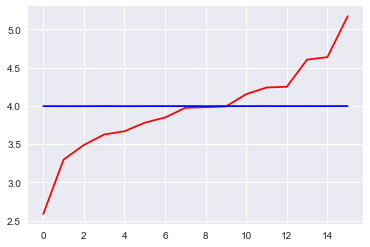

3810:1.1463276147842407	0.8061906695365906
3820:1.1309328079223633	0.8659307956695557
3830:1.1703462600708008	0.8524423837661743
3840:1.0558491945266724	0.913250744342804
3850:1.1929092407226562	0.9189491868019104
3860:1.0630998611450195	0.8648897409439087
3870:1.3220510482788086	0.9105046987533569
3880:1.1017811298370361	0.8565582633018494
3890:1.0524446964263916	0.8702802658081055
3900:1.1247029304504395	0.8869650363922119


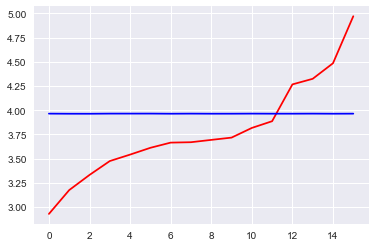

3910:1.116753101348877	0.8698793649673462
3920:1.1958972215652466	0.7611647844314575
3930:1.1837821006774902	0.892760694026947
3940:1.0732214450836182	0.8901273012161255
3950:1.044805645942688	0.9121432900428772
3960:1.0223443508148193	0.9116271734237671
3970:1.129417061805725	0.778031051158905
3980:1.109234094619751	0.8029351234436035
3990:1.2094290256500244	0.8881068825721741
4000:1.1032755374908447	0.9110424518585205


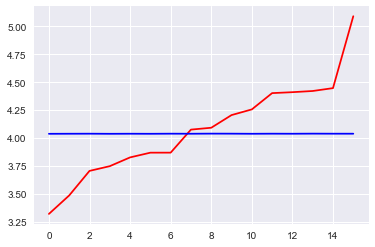

4010:0.9730502367019653	0.93971186876297
4020:1.0936121940612793	0.8900661468505859
4030:1.1123149394989014	0.9067176580429077
4040:1.2162895202636719	0.9531574249267578
4050:1.086337685585022	0.8796812295913696
4060:0.9562243223190308	0.9217246770858765
4070:1.0494755506515503	0.9214448928833008
4080:1.0851337909698486	0.8781864047050476
4090:1.1570748090744019	0.9014148712158203
4100:1.074394941329956	0.8940670490264893


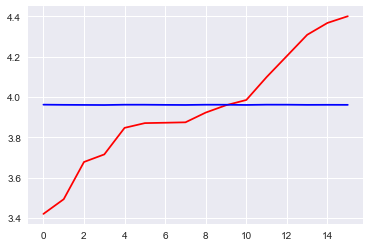

4110:1.0091220140457153	0.9481281042098999
4120:1.0695092678070068	0.8972529172897339
4130:1.07431960105896	0.9184588193893433
4140:1.0009323358535767	0.9865238070487976
4150:1.202078104019165	0.9111561179161072
4160:1.1920695304870605	0.9071396589279175
4170:0.9610506296157837	0.9658806920051575
4180:0.9721906781196594	0.9637105464935303
4190:1.2083380222320557	0.8558089733123779
4200:1.0456535816192627	0.9538499116897583


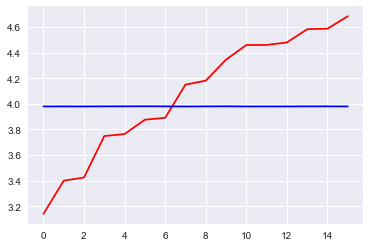

4210:1.0110392570495605	0.9748661518096924
4220:1.0994048118591309	0.9024415016174316
4230:1.2190701961517334	0.8583491444587708
4240:0.9909584522247314	0.9168760776519775
4250:1.0996026992797852	0.9626787304878235
4260:0.9899047613143921	0.9457489252090454
4270:1.0512471199035645	0.9150590896606445
4280:1.1228220462799072	0.8977422714233398
4290:1.0752208232879639	0.9720274209976196
4300:1.0737577676773071	0.9399320483207703


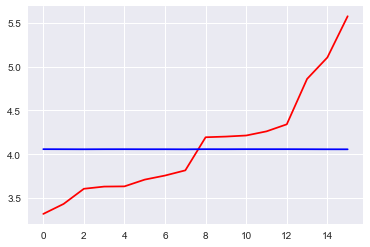

4310:0.9547417163848877	0.8662501573562622
4320:1.0084145069122314	0.9750962257385254
4330:1.0124461650848389	0.9864472150802612
4340:0.9689838290214539	0.987131655216217
4350:1.1931184530258179	0.9518179893493652
4360:1.0063339471817017	0.9550572633743286
4370:1.0555843114852905	0.976800799369812
4380:1.0597631931304932	0.9417240619659424
4390:1.0991106033325195	0.818447470664978
4400:1.0301820039749146	0.9991120100021362


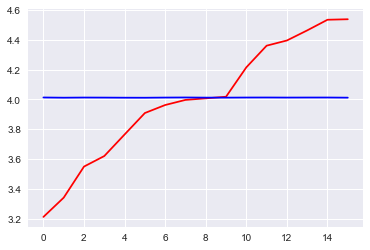

4410:0.8179268836975098	1.019484519958496
4420:0.9947872161865234	1.0015159845352173
4430:1.1090818643569946	0.908221960067749
4440:1.0333731174468994	1.0344772338867188
4450:0.8797513246536255	0.9729920625686646
4460:1.0222100019454956	0.9448949694633484
4470:1.0746489763259888	1.0014677047729492
4480:1.0536470413208008	0.9658263921737671
4490:1.020617127418518	0.9861867427825928
4500:1.0984280109405518	0.9822320938110352


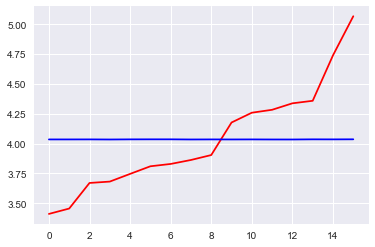

4510:0.9281007051467896	0.9838436841964722
4520:1.0025871992111206	1.007750153541565
4530:1.0288561582565308	0.971865177154541
4540:1.0673248767852783	1.0033296346664429
4550:1.0442396402359009	1.004811406135559
4560:1.0306214094161987	0.9950723052024841
4570:1.0795795917510986	1.022057056427002
4580:1.045841097831726	1.0303517580032349
4590:0.9534112215042114	0.9976213574409485
4600:0.9884834885597229	0.9069460034370422


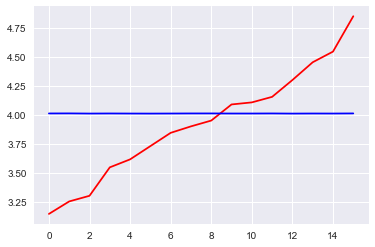

4610:0.9835436940193176	1.0067126750946045
4620:0.9200470447540283	0.9961810111999512
4630:0.9626489877700806	1.0079485177993774
4640:1.0256930589675903	1.0160883665084839
4650:0.9992011785507202	1.0391108989715576
4660:0.9505000114440918	1.0287318229675293
4670:0.9734086990356445	0.9683537483215332
4680:1.0220407247543335	0.9583613276481628
4690:0.8833069801330566	1.0731006860733032
4700:1.0768084526062012	0.9090392589569092


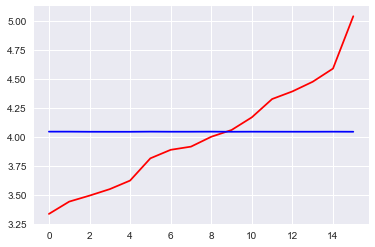

4710:0.8937285542488098	1.045891284942627
4720:0.9497770071029663	0.9911074638366699
4730:1.1415331363677979	0.944764256477356
4740:0.9907140731811523	0.9823005199432373
4750:1.122675895690918	1.0238734483718872
4760:1.1516295671463013	0.8736974596977234
4770:0.9268044233322144	1.030564785003662
4780:0.9442129135131836	1.0003741979599
4790:1.0858031511306763	0.9450192451477051
4800:1.1210999488830566	0.9841191172599792


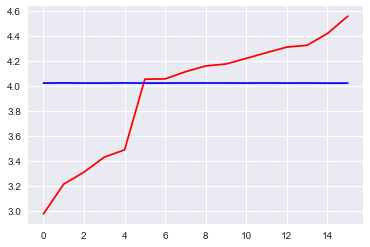

4810:1.3182874917984009	0.9949290752410889
4820:1.1130468845367432	0.9731564521789551
4830:0.8480250835418701	1.0753289461135864
4840:1.0071558952331543	1.0499622821807861
4850:0.8754187822341919	0.9582815170288086
4860:1.0142238140106201	0.9391028881072998
4870:0.9996533989906311	1.0013459920883179
4880:1.0134549140930176	1.0454919338226318
4890:0.9094718098640442	1.0684515237808228
4900:1.063688039779663	0.9839103817939758


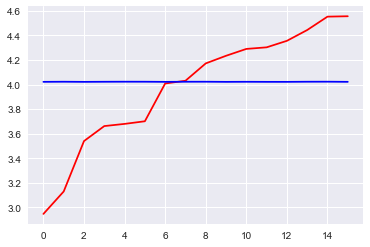

4910:0.9795490503311157	0.998724102973938
4920:1.0568978786468506	1.0847265720367432
4930:1.1306324005126953	1.0413248538970947
4940:1.0179104804992676	1.0011553764343262
4950:0.9437333345413208	1.0420397520065308
4960:0.986397385597229	1.0338890552520752
4970:1.085211157798767	1.077021837234497
4980:1.0147719383239746	0.9255069494247437
4990:0.97926265001297	1.038493275642395
5000:0.8983238935470581	1.0087933540344238


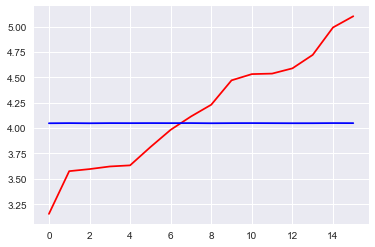

5010:0.9531030654907227	1.0417649745941162
5020:0.9961890578269958	1.0071303844451904
5030:1.165087103843689	1.053922176361084
5040:0.9379967451095581	1.0103025436401367
5050:0.9952229261398315	0.966850757598877
5060:0.9974376559257507	1.0332108736038208
5070:0.8861178159713745	1.060665488243103
5080:0.9802577495574951	1.0588669776916504
5090:0.9678092002868652	1.1278151273727417
5100:0.9183399677276611	1.0298662185668945


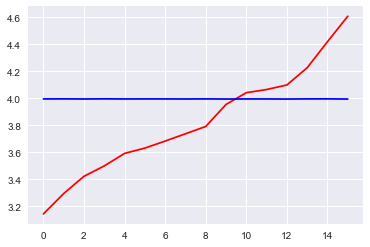

5110:1.099104881286621	1.010910987854004
5120:1.0131616592407227	1.0464892387390137
5130:0.9338871836662292	1.0805058479309082
5140:0.9580316543579102	1.026125431060791
5150:0.9575208425521851	1.0371838808059692
5160:0.8126475214958191	1.1689873933792114
5170:0.8540987968444824	1.043221354484558
5180:1.1274725198745728	1.01694917678833
5190:0.9290333986282349	1.057922124862671
5200:1.1047465801239014	1.0690456628799438


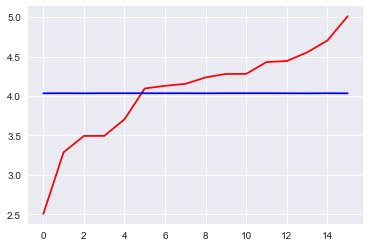

5210:0.83599853515625	1.116767406463623
5220:0.9810093641281128	1.0445094108581543
5230:1.0209689140319824	1.0467863082885742
5240:0.9945552349090576	1.0767014026641846
5250:0.760958731174469	1.1041288375854492
5260:0.9723910093307495	1.0259718894958496
5270:1.070734977722168	1.0203988552093506
5280:0.9464695453643799	0.9808976054191589
5290:0.8632630109786987	1.0729864835739136
5300:1.1215531826019287	1.0541067123413086


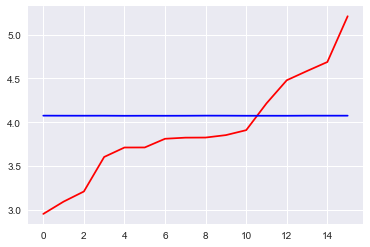

5310:1.031798005104065	1.0871977806091309
5320:1.0253410339355469	1.0546798706054688
5330:0.8610231876373291	1.1314914226531982
5340:0.9578899145126343	1.0284762382507324
5350:1.123321294784546	0.9880862236022949
5360:1.0051302909851074	1.053661823272705
5370:0.9195542931556702	1.0667719841003418
5380:0.7142283916473389	1.1296226978302002
5390:0.9652479887008667	1.0540974140167236
5400:0.951344907283783	1.0793665647506714


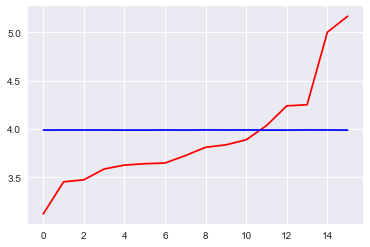

5410:0.809683620929718	1.0927700996398926
5420:0.8218862414360046	1.1479425430297852
5430:0.8864874839782715	1.0963895320892334
5440:0.9075482487678528	1.0847690105438232
5450:0.8844730854034424	1.057072401046753
5460:0.9605741500854492	1.109025239944458
5470:0.7626751661300659	1.1090104579925537
5480:0.9549756646156311	1.0972880125045776
5490:0.9045356512069702	1.1281464099884033
5500:1.0859225988388062	0.926349401473999


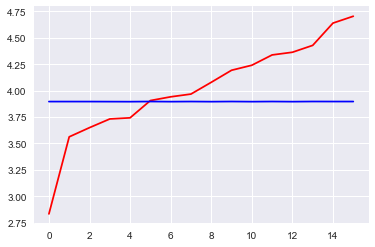

5510:0.8528963327407837	0.9678314328193665
5520:0.8944375514984131	1.0882396697998047
5530:0.7882755994796753	1.1478095054626465
5540:0.9558990597724915	0.9874875545501709
5550:0.8285607099533081	1.1547327041625977
5560:0.9522208571434021	1.0843093395233154
5570:1.047545075416565	1.0879173278808594
5580:0.8449670076370239	1.1650234460830688
5590:0.9289438724517822	1.0992679595947266
5600:0.8735926151275635	1.0866117477416992


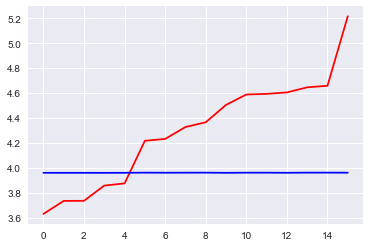

5610:1.002377986907959	0.982183575630188
5620:0.8705135583877563	1.1104549169540405
5630:0.9679911136627197	1.0341050624847412
5640:0.9073270559310913	1.086666464805603
5650:0.812369704246521	1.0634739398956299
5660:0.9040944576263428	1.089134693145752
5670:0.8499752879142761	1.1016335487365723
5680:0.910741925239563	1.1266982555389404
5690:0.872758150100708	1.1348291635513306
5700:0.8930649757385254	1.1199181079864502


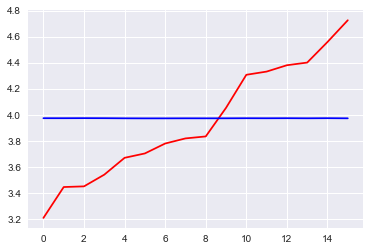

5710:0.918783962726593	1.1265708208084106
5720:0.880500853061676	1.05422842502594
5730:0.9078361988067627	1.1644325256347656
5740:0.9827254414558411	1.148087739944458
5750:1.0800390243530273	1.097894310951233
5760:0.8095724582672119	1.1437478065490723
5770:0.8040082454681396	1.1546447277069092
5780:0.8904716968536377	1.1100033521652222
5790:1.019789218902588	1.1061515808105469
5800:0.8770501613616943	1.1531108617782593


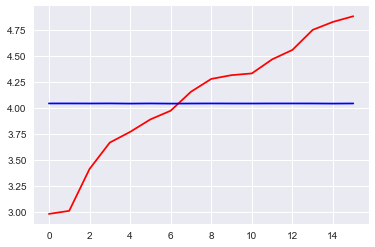

5810:0.8715789318084717	1.0964419841766357
5820:0.9620444774627686	1.1315335035324097
5830:1.0016416311264038	1.119822382926941
5840:1.0165736675262451	1.1429781913757324
5850:0.8559386730194092	1.0719525814056396
5860:0.8210229277610779	1.085540771484375
5870:0.9183008670806885	1.1377887725830078
5880:0.9165079593658447	1.056662678718567
5890:1.0205378532409668	1.1018832921981812
5900:0.8918779492378235	1.1137874126434326


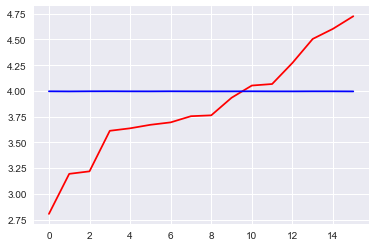

5910:0.8891912698745728	1.1396889686584473
5920:1.1541345119476318	1.0706276893615723
5930:1.1496580839157104	1.1246428489685059
5940:1.181460976600647	1.1347393989562988
5950:0.8264882564544678	1.1205487251281738
5960:0.9321898221969604	1.1156381368637085
5970:0.7925075888633728	1.0849928855895996
5980:0.8516682386398315	1.1318421363830566
5990:1.0760068893432617	1.0677615404129028
6000:0.9627771973609924	1.0790867805480957


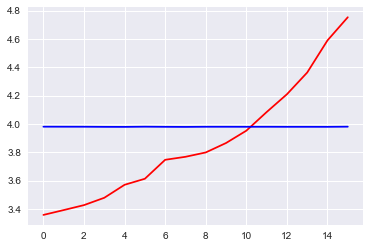

6010:0.8823171854019165	1.1527276039123535
6020:0.8345555067062378	1.1503372192382812
6030:0.790703535079956	1.1549447774887085
6040:0.8058822154998779	1.0810004472732544
6050:0.7316949367523193	1.1629173755645752
6060:0.9034411311149597	1.1248830556869507
6070:1.046534776687622	1.1399922370910645
6080:0.841724693775177	1.1494718790054321
6090:1.0511665344238281	1.0435035228729248
6100:0.9439005851745605	1.1313083171844482


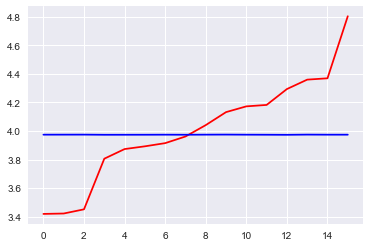

6110:1.1455786228179932	1.1124744415283203
6120:0.7367451190948486	1.1492365598678589
6130:0.859236478805542	1.1447227001190186
6140:0.9737681150436401	1.1319799423217773
6150:0.6922059059143066	1.1917457580566406
6160:0.7362402677536011	1.1850180625915527
6170:0.9150089621543884	1.1264631748199463
6180:1.003668189048767	1.0990688800811768
6190:0.8112966418266296	1.0977401733398438
6200:0.794389009475708	1.200092077255249


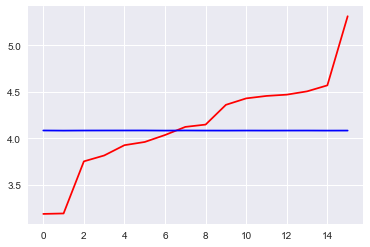

6210:0.9447710514068604	1.138410210609436
6220:0.7706384658813477	1.162743330001831
6230:0.8421677947044373	1.1584655046463013
6240:0.6484147310256958	1.1906174421310425
6250:0.9731398820877075	1.1545549631118774
6260:0.8733553886413574	1.1192026138305664
6270:0.9585740566253662	1.207172155380249
6280:0.7158032655715942	1.1475653648376465
6290:0.7871252298355103	1.1572811603546143
6300:0.819299578666687	1.146836757659912


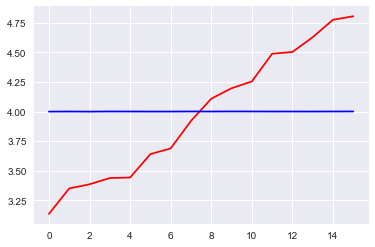

6310:0.7818975448608398	1.194234848022461
6320:0.8238060474395752	1.1372036933898926
6330:0.9903345704078674	1.1677637100219727
6340:1.0355929136276245	1.1831297874450684
6350:1.094208002090454	1.081360101699829
6360:0.7677081823348999	1.0947571992874146
6370:0.9434587359428406	1.1540648937225342
6380:0.7891797423362732	1.1409730911254883
6390:0.7372651100158691	1.09958815574646
6400:0.8249472975730896	1.2254712581634521


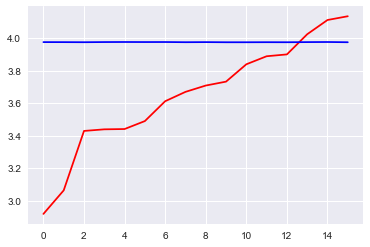

6410:0.8705663681030273	1.126485824584961
6420:1.016566514968872	1.114955186843872
6430:0.8782610893249512	1.145775556564331
6440:1.023617148399353	1.1189121007919312
6450:0.8854961395263672	1.1640024185180664
6460:0.9129890203475952	1.1472394466400146
6470:0.912498950958252	1.1874749660491943
6480:0.660979151725769	1.193039059638977
6490:0.8880038261413574	1.0981241464614868
6500:0.8613108396530151	1.2362080812454224


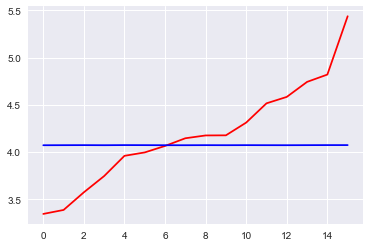

6510:0.7999030351638794	1.1334478855133057
6520:0.8057145476341248	1.1739094257354736
6530:1.0337673425674438	1.1730669736862183
6540:0.8050968647003174	1.168464183807373
6550:0.7960686087608337	1.1367111206054688
6560:0.8456493616104126	1.1532034873962402
6570:0.8861018419265747	1.1863293647766113
6580:0.9103898406028748	1.2153065204620361
6590:1.2097057104110718	1.1719810962677002
6600:0.8042014837265015	1.2156341075897217


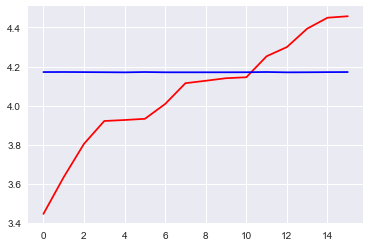

6610:0.8605233430862427	1.1475682258605957
6620:0.8270152807235718	1.1642447710037231
6630:0.7779790759086609	1.1679878234863281
6640:1.034816026687622	1.1418224573135376
6650:0.8317162394523621	1.1784571409225464
6660:0.8729718923568726	1.165189504623413
6670:0.8703081607818604	1.2045867443084717
6680:0.7018563747406006	1.2343189716339111
6690:0.8246214389801025	1.1366639137268066
6700:0.8753683567047119	1.194632887840271


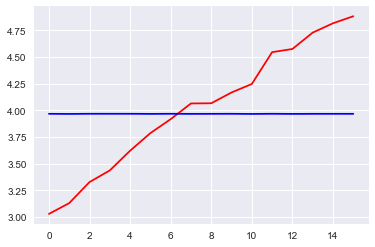

6710:0.7931963205337524	1.186970591545105
6720:0.7060914039611816	1.1869081258773804
6730:0.8952497243881226	1.2802201509475708
6740:0.7110015153884888	1.3023154735565186
6750:0.89689040184021	1.2172505855560303
6760:0.8082743287086487	1.201745867729187
6770:0.8818446397781372	1.1207399368286133
6780:0.7937493324279785	1.197811484336853
6790:0.8700383901596069	1.1435970067977905
6800:0.7000516653060913	1.2122926712036133


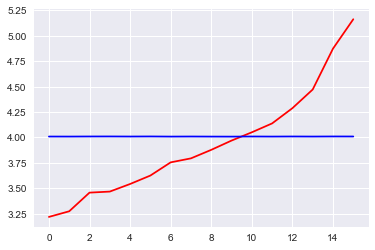

6810:0.9697318077087402	1.2130610942840576
6820:0.9443885087966919	1.1429489850997925
6830:0.9958480596542358	1.1510862112045288
6840:0.8041431903839111	1.191864252090454
6850:0.9744551777839661	1.0871354341506958
6860:0.849892258644104	1.1897187232971191
6870:0.9047644138336182	1.1499193906784058
6880:0.8146919012069702	1.196494698524475
6890:0.828417181968689	1.2007052898406982
6900:0.8144365549087524	1.2226941585540771


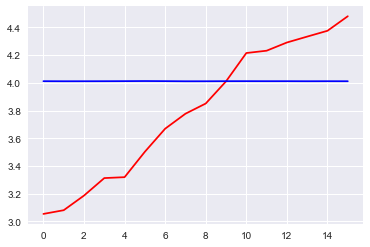

6910:0.6734316349029541	1.1802129745483398
6920:0.8590332269668579	1.1669775247573853
6930:0.8318074345588684	1.2358189821243286
6940:0.8644939661026001	1.1443699598312378
6950:0.85859215259552	1.1577537059783936
6960:1.0013279914855957	1.1842600107192993
6970:0.698833167552948	1.2075648307800293
6980:0.8955114483833313	1.1824285984039307
6990:0.8172754645347595	1.179491639137268
7000:0.7480823993682861	1.199506163597107


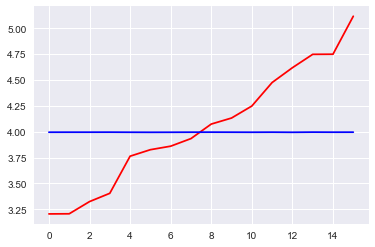

7010:0.6926727294921875	1.2220027446746826
7020:0.9680584669113159	1.2283334732055664
7030:0.9349507093429565	1.2329685688018799
7040:0.7607569098472595	1.2713329792022705
7050:0.7198745608329773	1.1889643669128418
7060:0.8307309746742249	1.1668720245361328
7070:0.9764600992202759	1.1452248096466064
7080:0.7451715469360352	1.2063543796539307
7090:0.6933223009109497	1.2381577491760254
7100:0.8518878221511841	1.0377833843231201


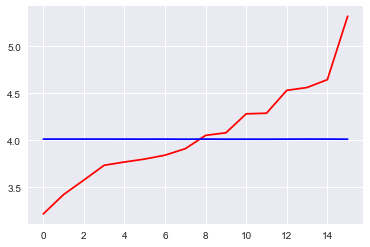

7110:0.7358642816543579	1.2389025688171387
7120:0.7406054139137268	1.1907963752746582
7130:0.8116486072540283	1.1630809307098389
7140:0.760901927947998	1.2154278755187988
7150:0.8464274406433105	1.2394442558288574
7160:0.8433101773262024	1.1857290267944336
7170:0.6325114965438843	1.2545419931411743
7180:0.7887547016143799	1.2570905685424805
7190:0.689079225063324	1.2466435432434082
7200:0.6528831720352173	1.2447192668914795


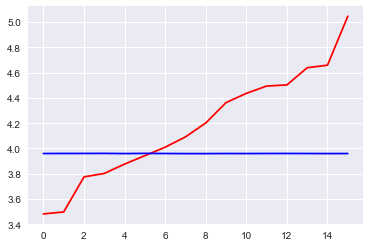

7210:0.7614157199859619	1.2994358539581299
7220:0.7973873615264893	1.2372676134109497
7230:0.6540790796279907	1.2970860004425049
7240:0.714917004108429	1.2485333681106567
7250:0.9371391534805298	1.1944997310638428
7260:0.891481339931488	1.251429796218872
7270:0.7504881620407104	1.1541122198104858
7280:0.8210100531578064	1.2260346412658691
7290:0.9325432181358337	1.3271276950836182
7300:0.8337050676345825	1.1802949905395508


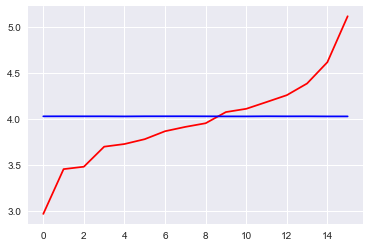

7310:0.9994173049926758	1.1675982475280762
7320:0.9003158211708069	1.17461097240448
7330:0.8798221945762634	1.2191320657730103
7340:1.0278043746948242	1.1666244268417358
7350:0.984987735748291	1.1211634874343872
7360:0.7460784316062927	1.1791791915893555
7370:0.8854146599769592	1.1782779693603516
7380:0.8075703382492065	1.223081350326538
7390:0.8252766132354736	1.2243608236312866
7400:0.8196792602539062	1.2084214687347412


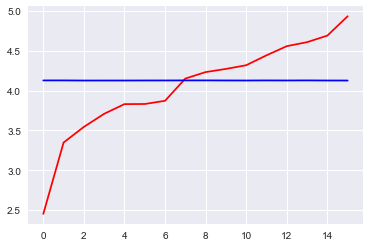

7410:0.6539264917373657	1.2596186399459839
7420:0.842200756072998	1.230675458908081
7430:0.8978046178817749	1.2263665199279785
7440:0.9231445789337158	1.196051836013794
7450:0.7787066698074341	1.2563204765319824
7460:0.8847612142562866	1.172088623046875
7470:0.7020920515060425	1.2538743019104004
7480:0.728422224521637	1.2756757736206055
7490:0.7281821966171265	1.2902648448944092
7500:0.8412909507751465	1.2699127197265625


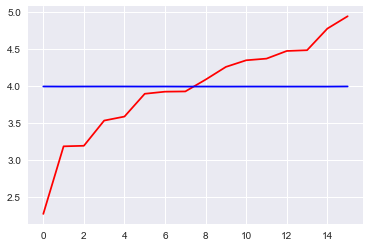

7510:0.8891167640686035	1.2991971969604492
7520:0.6942917108535767	1.20164155960083
7530:0.7165173292160034	1.271630048751831
7540:0.63228440284729	1.2392241954803467
7550:0.806338906288147	1.285662055015564
7560:0.8011395335197449	1.2235572338104248
7570:0.9472335577011108	1.2158368825912476
7580:0.8654657602310181	1.2457275390625
7590:0.832874059677124	1.195713996887207
7600:0.7179762125015259	1.2567168474197388


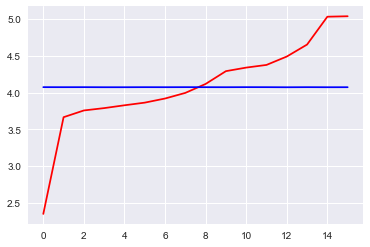

7610:0.6780705451965332	1.2626293897628784
7620:0.7977181077003479	1.256105899810791
7630:0.7225722074508667	1.2882412672042847
7640:0.8407745957374573	1.221535086631775
7650:0.7662390470504761	1.2098075151443481
7660:0.7441253662109375	1.2215652465820312
7670:0.8769567608833313	1.2080882787704468
7680:0.6664182543754578	1.246349573135376
7690:0.811336874961853	1.230624794960022
7700:0.5400688648223877	1.2875102758407593


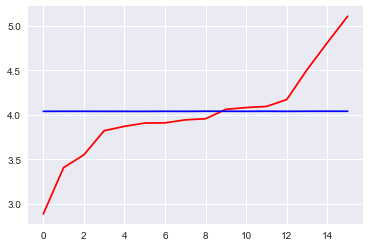

7710:0.8317803144454956	1.1734356880187988
7720:0.8429170846939087	1.257371187210083
7730:0.7794016003608704	1.2158100605010986
7740:0.6281687021255493	1.2017123699188232
7750:0.7487180829048157	1.2995280027389526
7760:0.9030902981758118	1.2465906143188477
7770:0.8327102661132812	1.253262996673584
7780:0.879615306854248	1.2508043050765991
7790:0.837529182434082	1.2425509691238403
7800:0.9838994145393372	1.2353445291519165


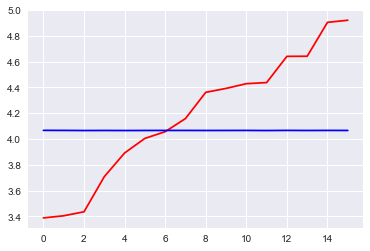

7810:0.8519073724746704	1.220564365386963
7820:0.6056917905807495	1.1863319873809814
7830:0.7565617561340332	1.1955686807632446
7840:0.7312124967575073	1.2523980140686035
7850:0.7345285415649414	1.2594960927963257
7860:0.6835469007492065	1.2807950973510742
7870:0.6068132519721985	1.2601478099822998
7880:0.791695237159729	1.2667746543884277
7890:0.6317135691642761	1.3073770999908447
7900:0.7228267192840576	1.2639966011047363


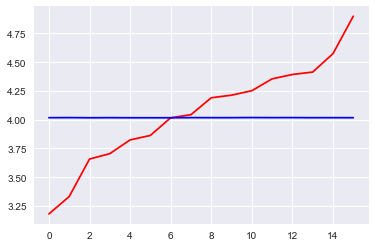

7910:0.847230076789856	1.2244188785552979
7920:0.790532112121582	1.2794997692108154
7930:0.9763542413711548	1.1869258880615234
7940:0.8020596504211426	1.2749578952789307
7950:0.791178286075592	1.2234325408935547
7960:1.0177695751190186	1.208452582359314
7970:0.7323988080024719	1.241353154182434
7980:0.7947712540626526	1.2829055786132812
7990:0.7916331887245178	1.2405803203582764
8000:0.7986642122268677	1.2229325771331787


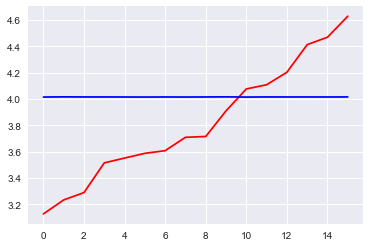

8010:0.9413313269615173	1.1591746807098389
8020:0.685132622718811	1.295097827911377
8030:0.604361355304718	1.2562816143035889
8040:0.7723321318626404	1.2340102195739746
8050:0.858661413192749	1.2288156747817993
8060:0.8240112066268921	1.2410297393798828
8070:0.6636207699775696	1.2521915435791016
8080:0.7419860363006592	1.2486848831176758
8090:0.8143675327301025	1.2807612419128418
8100:0.9837228059768677	1.2392855882644653


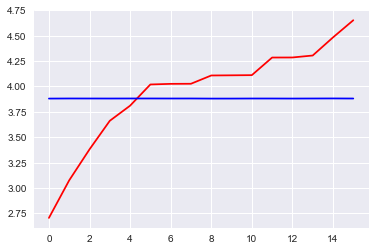

8110:0.9928102493286133	1.212437391281128
8120:0.6570441126823425	1.2742342948913574
8130:0.8887273073196411	1.2446404695510864
8140:0.9042932987213135	1.1936582326889038
8150:0.7712538838386536	1.2253293991088867
8160:0.8686807751655579	1.2196452617645264
8170:0.7734959721565247	1.2361509799957275
8180:0.7997456789016724	1.2313185930252075
8190:0.8211828470230103	1.2549026012420654
8200:0.7209833860397339	1.231128215789795


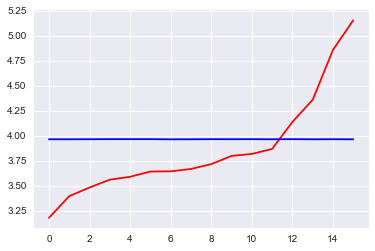

8210:0.7524662017822266	1.2528952360153198
8220:0.7366907000541687	1.266343593597412
8230:0.9130101203918457	1.2076255083084106
8240:0.7992350459098816	1.278656244277954
8250:1.0130093097686768	1.2448129653930664
8260:0.6790674924850464	1.2905149459838867
8270:0.9201540350914001	1.2638624906539917
8280:0.8962665796279907	1.2510986328125
8290:0.6472875475883484	1.2778761386871338
8300:0.827601432800293	1.2749402523040771


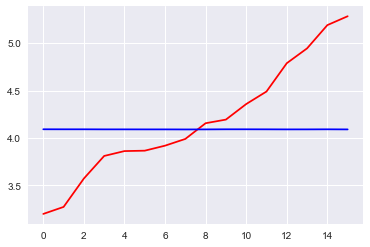

8310:0.5980896353721619	1.2738893032073975
8320:0.9415816068649292	1.285172700881958
8330:0.7963441014289856	1.2369672060012817
8340:0.7694751024246216	1.2200028896331787
8350:0.6758228540420532	1.2711197137832642
8360:0.8895397782325745	1.1782684326171875
8370:0.8575769662857056	1.2238984107971191
8380:0.7532640695571899	1.1794137954711914
8390:0.747028112411499	1.2398104667663574
8400:0.8665351867675781	1.2309644222259521


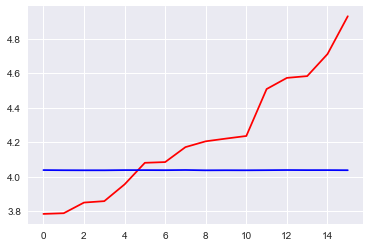

8410:0.8699526786804199	1.2466914653778076
8420:0.770488977432251	1.2272545099258423
8430:0.8879534602165222	1.211098551750183
8440:0.8515037894248962	1.185861587524414
8450:0.8174252510070801	1.1831597089767456
8460:0.7836887836456299	1.228682518005371
8470:0.7349070310592651	1.2443382740020752
8480:0.705784797668457	1.285531997680664
8490:0.8293743133544922	1.2643418312072754
8500:0.670430064201355	1.2453625202178955


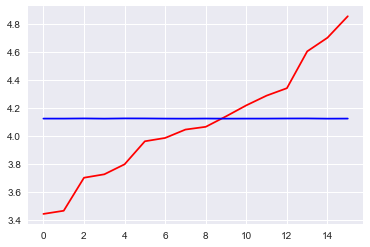

8510:0.9583432674407959	1.2203443050384521
8520:0.7780249118804932	1.2794888019561768
8530:0.827604353427887	1.2324401140213013
8540:0.6857612133026123	1.2954378128051758
8550:0.6578904986381531	1.282533884048462
8560:0.7758873105049133	1.2309410572052002
8570:0.6679766178131104	1.2491240501403809
8580:0.7858703136444092	1.2543983459472656
8590:0.7555472254753113	1.2604347467422485
8600:0.6626579165458679	1.2222901582717896


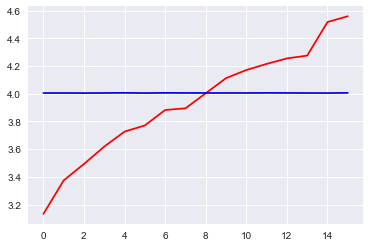

8610:0.7978004217147827	1.2633136510849
8620:0.7117937207221985	1.2734043598175049
8630:0.77596116065979	1.2724359035491943
8640:0.7206555604934692	1.2640800476074219
8650:0.8252009153366089	1.2715282440185547
8660:0.6435256004333496	1.245199203491211
8670:0.8469107747077942	1.2444783449172974
8680:0.7112388014793396	1.2972633838653564
8690:0.728267252445221	1.2930948734283447
8700:0.7227108478546143	1.2894052267074585


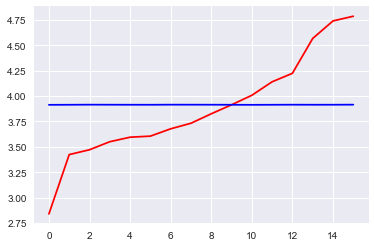

8710:0.9312262535095215	1.2758665084838867
8720:0.7744107246398926	1.2763867378234863
8730:0.6834701299667358	1.3066374063491821
8740:0.5999765396118164	1.342128038406372
8750:0.6253633499145508	1.361832857131958
8760:0.8769751787185669	1.2233675718307495
8770:0.7488269805908203	1.2850487232208252
8780:0.7846742868423462	1.1856848001480103
8790:0.7793302536010742	1.2612535953521729
8800:0.63929283618927	1.2546837329864502


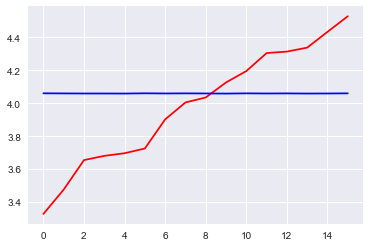

8810:0.8436751365661621	1.2466809749603271
8820:0.7315919399261475	1.251123309135437
8830:0.7620148658752441	1.2830193042755127
8840:0.7135976552963257	1.289442777633667
8850:0.8630475997924805	1.2644896507263184
8860:0.7725870609283447	1.2667808532714844
8870:0.7017120122909546	1.2842533588409424
8880:0.8624552488327026	1.2660917043685913
8890:0.7297300100326538	1.2977197170257568
8900:0.6730324029922485	1.2922545671463013


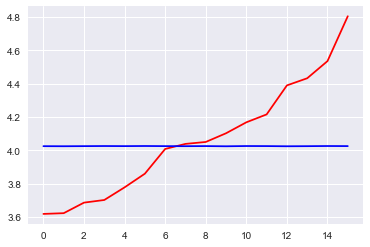

8910:0.6217107772827148	1.2599225044250488
8920:0.8071834444999695	1.2749297618865967
8930:0.8664902448654175	1.268039345741272
8940:0.7557113766670227	1.3093347549438477
8950:0.7588716745376587	1.3413245677947998
8960:0.6770579814910889	1.365936040878296
8970:0.8675310015678406	1.2372061014175415
8980:0.7894832491874695	1.2459352016448975
8990:0.8152453899383545	1.2821074724197388
9000:0.7483313083648682	1.2785015106201172


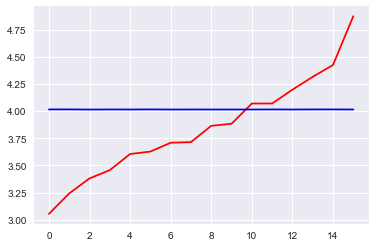

9010:0.8483316898345947	1.2475758790969849
9020:0.5771500468254089	1.302025318145752
9030:0.7631794214248657	1.2748996019363403
9040:0.9214180707931519	1.3134510517120361
9050:0.7589192390441895	1.2875800132751465
9060:0.7867560386657715	1.286363124847412
9070:0.8108092546463013	1.3027598857879639
9080:0.7545937299728394	1.2606579065322876
9090:0.6050055027008057	1.341031551361084
9100:0.6512113809585571	1.301939606666565


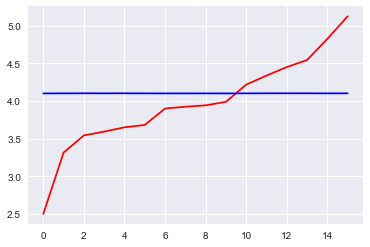

9110:0.8103823661804199	1.2939079999923706
9120:0.7446689605712891	1.2168830633163452
9130:0.992732584476471	1.2939529418945312
9140:0.6968671083450317	1.284794569015503
9150:0.7464215755462646	1.194657325744629
9160:0.7247464656829834	1.280146837234497
9170:0.9005005359649658	1.2798211574554443
9180:0.7519799470901489	1.209364414215088
9190:0.6889839768409729	1.2687170505523682
9200:0.7159135341644287	1.2874715328216553


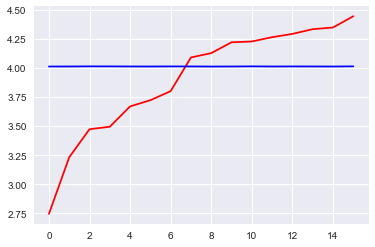

9210:0.857775866985321	1.222208023071289
9220:0.6079584360122681	1.305375337600708
9230:0.6513432264328003	1.267204999923706
9240:0.8384978771209717	1.307533860206604
9250:0.782909631729126	1.2746946811676025
9260:0.7892714738845825	1.3562315702438354
9270:0.9659229516983032	1.332810640335083
9280:0.8496126532554626	1.2820680141448975
9290:0.6518597602844238	1.2156243324279785
9300:0.8206568956375122	1.2712278366088867


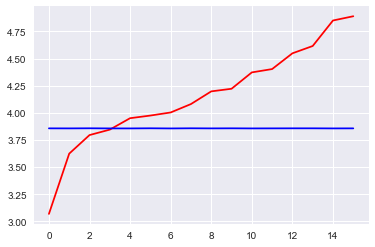

9310:0.842194676399231	1.3216917514801025
9320:0.7471432685852051	1.3556501865386963
9330:0.9419504404067993	1.3400158882141113
9340:0.7012288570404053	1.3098268508911133
9350:0.8535915017127991	1.264109492301941
9360:0.5824756026268005	1.304008960723877
9370:0.8147421479225159	1.2879213094711304
9380:0.6820279359817505	1.293875813484192
9390:0.7459453344345093	1.28901207447052
9400:0.7779980301856995	1.2904694080352783


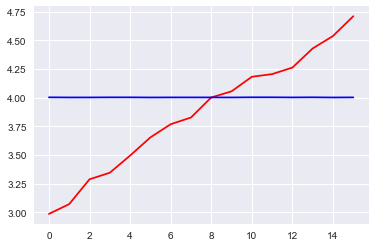

9410:0.9415323734283447	1.269975185394287
9420:0.9557870626449585	1.2754056453704834
9430:0.6254035234451294	1.3203192949295044
9440:0.9967727661132812	1.1699421405792236
9450:0.732911229133606	1.332181692123413
9460:0.6941150426864624	1.2614027261734009
9470:1.1676312685012817	1.2194595336914062
9480:0.7156631350517273	1.2652385234832764
9490:0.5856691002845764	1.3309394121170044
9500:0.5691466331481934	1.3422582149505615


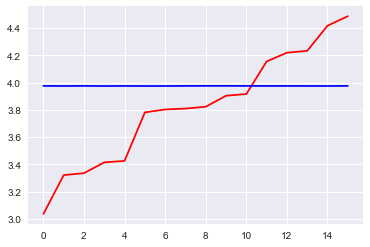

9510:0.5993838310241699	1.4008338451385498
9520:0.8831210136413574	1.316330909729004
9530:0.8967316150665283	1.3610045909881592
9540:0.7371339797973633	1.342268943786621
9550:0.7794873118400574	1.3481495380401611
9560:0.5833006501197815	1.3221909999847412
9570:0.7693313360214233	1.2903410196304321
9580:0.5911242961883545	1.2800132036209106
9590:0.8496389985084534	1.229579210281372
9600:0.5508193969726562	1.364990234375


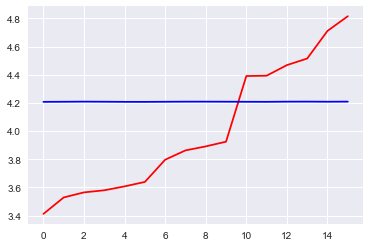

9610:0.5873991250991821	1.3506793975830078
9620:0.6338025331497192	1.305757999420166
9630:0.7061259746551514	1.305485725402832
9640:0.7659029364585876	1.277956247329712
9650:0.890739917755127	1.3216032981872559
9660:0.7701043486595154	1.300907015800476
9670:0.7206114530563354	1.2822158336639404
9680:0.7972882986068726	1.267026424407959
9690:0.9710968136787415	1.2918832302093506
9700:0.666043758392334	1.2813255786895752


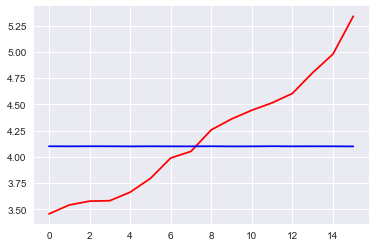

9710:0.7296543717384338	1.2788599729537964
9720:0.7562248110771179	1.299116849899292
9730:0.9906746745109558	1.2688212394714355
9740:0.661604106426239	1.2810804843902588
9750:0.681519627571106	1.2908945083618164
9760:0.7483107447624207	1.3005304336547852
9770:0.8904621601104736	1.2082390785217285
9780:0.5789850950241089	1.3407821655273438
9790:0.7279744744300842	1.3182772397994995
9800:0.859991192817688	1.333446741104126


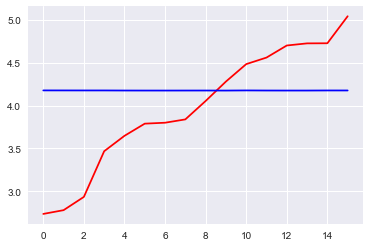

9810:0.6316290497779846	1.305861473083496
9820:0.7117681503295898	1.298677921295166
9830:0.7211766242980957	1.2886135578155518
9840:0.5689803957939148	1.3349535465240479
9850:0.9376586079597473	1.2697608470916748
9860:0.7499608397483826	1.2591586112976074
9870:0.8201485872268677	1.275766134262085
9880:0.610772430896759	1.2952489852905273
9890:0.754230260848999	1.2863657474517822
9900:0.7211721539497375	1.2764360904693604


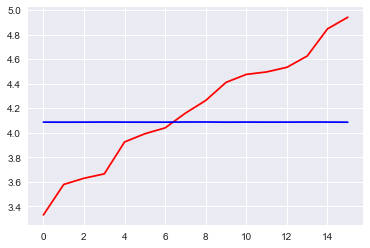

9910:0.6376148462295532	1.3162513971328735
9920:0.7320477962493896	1.295824408531189
9930:0.7229833006858826	1.354597568511963
9940:0.8688930869102478	1.3529834747314453
9950:0.8006703853607178	1.3157944679260254
9960:0.7302627563476562	1.3143119812011719
9970:0.6654588580131531	1.3081287145614624
9980:0.7134926915168762	1.296743392944336
9990:0.7441571950912476	1.3436245918273926
10000:0.680686354637146	1.30928635597229


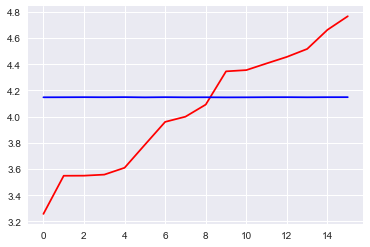

10010:0.9361056089401245	1.3175690174102783
10020:0.8798555731773376	1.302467703819275
10030:0.7014361619949341	1.313430666923523
10040:0.7967014312744141	1.3092248439788818
10050:0.9360562562942505	1.266823410987854
10060:0.7092263698577881	1.2701420783996582
10070:0.6868735551834106	1.2694251537322998
10080:0.7630128860473633	1.2890708446502686
10090:0.6012680530548096	1.298974871635437
10100:0.6013849377632141	1.3196901082992554


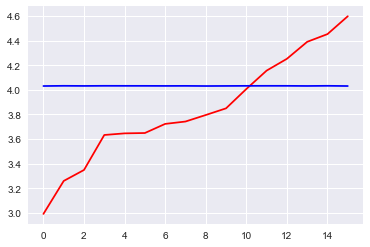

10110:0.7361097931861877	1.3432893753051758
10120:0.7776709794998169	1.2848619222640991
10130:0.9357105493545532	1.2590677738189697
10140:0.7708752155303955	1.2649484872817993
10150:0.6847829222679138	1.2641332149505615
10160:0.7572761178016663	1.2893391847610474
10170:0.741645872592926	1.3189005851745605
10180:0.6346136331558228	1.2889187335968018
10190:0.6966365575790405	1.3065078258514404
10200:0.6556079387664795	1.332399606704712


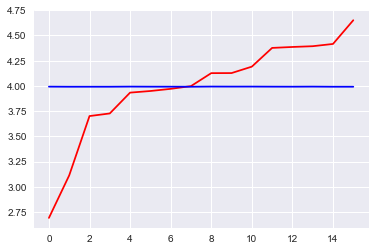

10210:0.7334332466125488	1.304633617401123
10220:0.5416368246078491	1.307423710823059
10230:0.6458655595779419	1.3565024137496948
10240:0.4982571601867676	1.3317325115203857
10250:0.5391733646392822	1.3748936653137207
10260:0.5765606164932251	1.3782176971435547
10270:0.9250715970993042	1.3443939685821533
10280:0.8637967705726624	1.3387044668197632
10290:0.7576825618743896	1.3229973316192627
10300:0.6951220631599426	1.3263583183288574


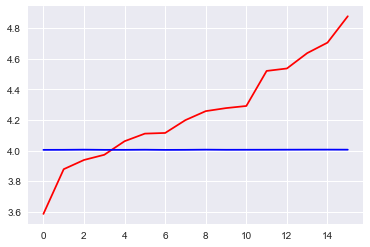

10310:0.6164205074310303	1.311164140701294
10320:0.7508823871612549	1.29362154006958
10330:0.826870858669281	1.295255422592163
10340:0.5954643487930298	1.3708730936050415
10350:0.8836944103240967	1.342362880706787
10360:0.6934278011322021	1.358528971672058
10370:0.6958931684494019	1.3348667621612549
10380:0.7557277679443359	1.296905755996704
10390:0.796269953250885	1.34569251537323
10400:0.7376303672790527	1.3134559392929077


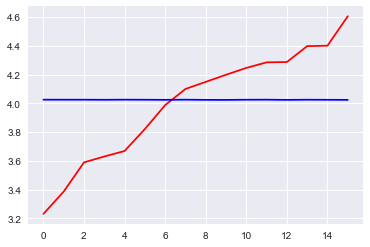

10410:0.7029311656951904	1.3240426778793335
10420:0.7435003519058228	1.281254768371582
10430:0.6504711508750916	1.3376390933990479
10440:0.757692277431488	1.3183485269546509
10450:0.7711682319641113	1.3431346416473389
10460:0.574539303779602	1.3311976194381714
10470:0.589414656162262	1.371496319770813
10480:0.7049287557601929	1.3550785779953003
10490:0.8249233365058899	1.3187974691390991
10500:1.0260009765625	1.2981680631637573


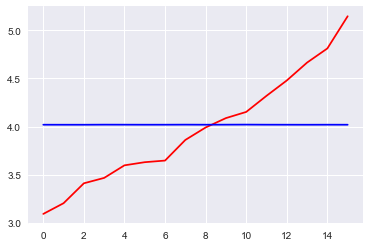

10510:0.6285672187805176	1.2944746017456055
10520:0.6911419034004211	1.2999494075775146
10530:0.5235946178436279	1.3258941173553467
10540:0.7991678714752197	1.3223254680633545
10550:0.8179292678833008	1.2588934898376465
10560:0.6761243343353271	1.3127893209457397
10570:0.665698766708374	1.315809965133667
10580:0.8841713070869446	1.3158388137817383
10590:0.7693446278572083	1.2716705799102783
10600:0.6511368751525879	1.3127630949020386


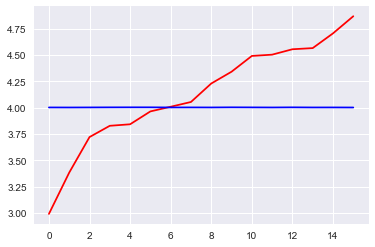

10610:0.7236931920051575	1.3168485164642334
10620:0.9004701375961304	1.2970590591430664
10630:0.6829270720481873	1.2906665802001953
10640:0.9409595727920532	1.2795684337615967
10650:0.8037276268005371	1.2783939838409424
10660:0.8005101084709167	1.2776153087615967
10670:0.6529519557952881	1.2867921590805054
10680:0.5589615106582642	1.322797179222107
10690:0.7832545042037964	1.2817890644073486
10700:0.6836453080177307	1.327242136001587


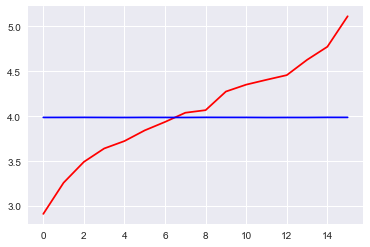

10710:0.5827476978302002	1.2654660940170288
10720:0.754849374294281	1.3508574962615967
10730:0.7151989936828613	1.2966985702514648
10740:1.0237088203430176	1.318415880203247
10750:0.7907788753509521	1.2827304601669312
10760:0.5666711926460266	1.302611231803894
10770:0.7058123350143433	1.2837852239608765
10780:0.6572252511978149	1.2837926149368286
10790:0.8185551166534424	1.2508556842803955
10800:0.8055449724197388	1.2670927047729492


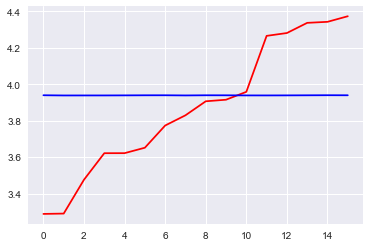

10810:0.5647931098937988	1.3083000183105469
10820:0.7209372520446777	1.2959800958633423
10830:0.7191917896270752	1.302535891532898
10840:0.8121634721755981	1.377591848373413
10850:0.8777559995651245	1.3354237079620361
10860:0.7918576002120972	1.3179924488067627
10870:0.8824874758720398	1.2896056175231934
10880:0.8019630908966064	1.2968575954437256
10890:0.7829750776290894	1.3183696269989014
10900:0.6195322275161743	1.314691185951233


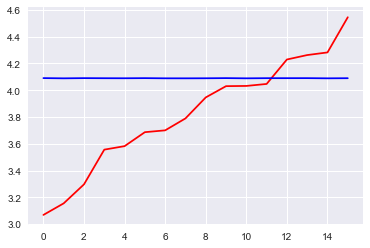

10910:0.7171972393989563	1.3060044050216675
10920:0.700402557849884	1.299001932144165
10930:0.664068341255188	1.3299771547317505
10940:0.7283356189727783	1.3007774353027344
10950:0.7193117141723633	1.3372999429702759
10960:0.584740936756134	1.350928783416748
10970:0.4967207610607147	1.3576939105987549
10980:0.7372077107429504	1.339521884918213
10990:0.9114755988121033	1.2940529584884644
11000:0.7037677764892578	1.2811639308929443


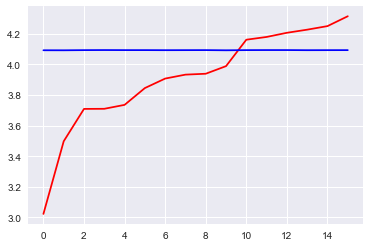

11010:0.5581237077713013	1.3240821361541748
11020:0.882314920425415	1.3126935958862305
11030:0.7923738956451416	1.3209550380706787
11040:0.5252036452293396	1.3203389644622803
11050:0.7488356828689575	1.3351845741271973
11060:0.6103243231773376	1.3102378845214844
11070:0.6403040885925293	1.3064285516738892
11080:0.5965323448181152	1.314483404159546
11090:0.5082803964614868	1.379730224609375
11100:0.8027746081352234	1.3443118333816528


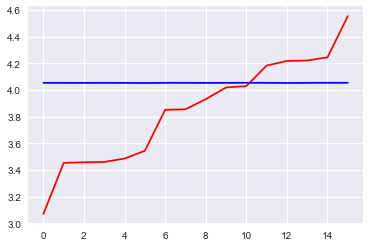

11110:0.7302736043930054	1.3000315427780151
11120:0.5626293420791626	1.3315519094467163
11130:0.9283517599105835	1.3148242235183716
11140:0.7586157917976379	1.3255314826965332
11150:0.7225541472434998	1.316304326057434
11160:0.6781342029571533	1.3019440174102783
11170:0.8028943538665771	1.3056610822677612
11180:0.5694001913070679	1.3106858730316162
11190:0.696989119052887	1.3139795064926147
11200:0.6926367282867432	1.3385288715362549


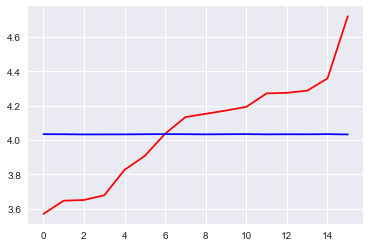

11210:0.8498815894126892	1.34372079372406
11220:0.7780966758728027	1.36893630027771
11230:0.6424620151519775	1.3520516157150269
11240:0.7449609041213989	1.3011116981506348
11250:0.9691107273101807	1.283516764640808
11260:0.8067031502723694	1.2663887739181519
11270:0.7472851276397705	1.2754783630371094
11280:0.6481276750564575	1.2900786399841309
11290:0.7142333388328552	1.3217041492462158
11300:0.6184262633323669	1.331634759902954


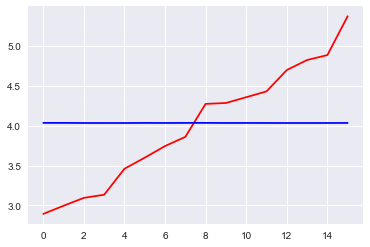

11310:0.6641827821731567	1.32300865650177
11320:0.6761962175369263	1.3061681985855103
11330:0.8505079746246338	1.2841718196868896
11340:0.7832226753234863	1.2863245010375977
11350:0.7172397375106812	1.3247921466827393
11360:0.6007084846496582	1.3159149885177612
11370:0.6667667627334595	1.341032862663269
11380:0.6917948722839355	1.328994870185852
11390:0.8429455757141113	1.307260274887085
11400:0.6814935803413391	1.3514907360076904


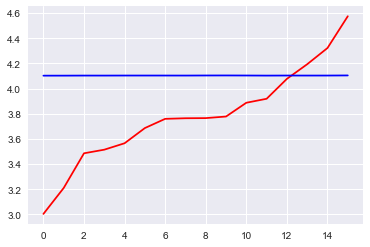

11410:0.6402062773704529	1.3432334661483765
11420:0.5958759784698486	1.3499842882156372
11430:0.6315027475357056	1.3854094743728638
11440:0.6070054769515991	1.3336373567581177
11450:0.7294434309005737	1.4004402160644531
11460:0.743398904800415	1.4114681482315063
11470:0.6367833614349365	1.3732423782348633
11480:0.6715822219848633	1.3512852191925049
11490:0.9120728969573975	1.3447116613388062
11500:0.6573517322540283	1.343813419342041


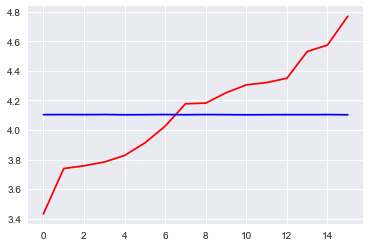

11510:0.847987711429596	1.3442710638046265
11520:0.4660094976425171	1.3745626211166382
11530:0.7416968941688538	1.3464022874832153
11540:0.5985361337661743	1.3564633131027222
11550:0.7635347843170166	1.3324707746505737
11560:0.7954640984535217	1.3494768142700195
11570:0.6627795100212097	1.3464176654815674
11580:0.6439104676246643	1.3219242095947266
11590:0.7905588150024414	1.32480788230896
11600:0.8459494709968567	1.2823600769042969


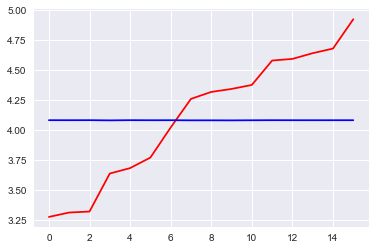

11610:0.6889705657958984	1.337496042251587
11620:0.8215794563293457	1.3113985061645508
11630:0.5280774831771851	1.30807626247406
11640:0.5702818036079407	1.2427644729614258
11650:0.6344559192657471	1.2473446130752563
11660:0.9085512161254883	1.2983218431472778
11670:0.9025331735610962	1.3127820491790771
11680:0.6023570895195007	1.324798345565796
11690:0.6292228698730469	1.3108489513397217
11700:0.719907820224762	1.3032314777374268


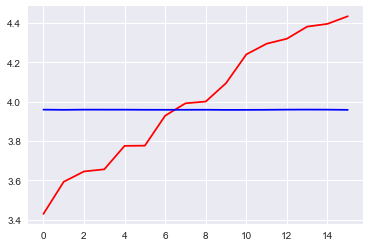

11710:0.7108691334724426	1.297375202178955
11720:0.6461707353591919	1.3259437084197998
11730:0.5000474452972412	1.3427329063415527
11740:0.8200712203979492	1.3504738807678223
11750:0.7484561204910278	1.3380846977233887
11760:0.6458607316017151	1.3316493034362793
11770:0.7863809466362	1.309440016746521
11780:0.9984432458877563	1.2844892740249634
11790:0.7367116212844849	1.2999933958053589
11800:0.851485550403595	1.2519501447677612


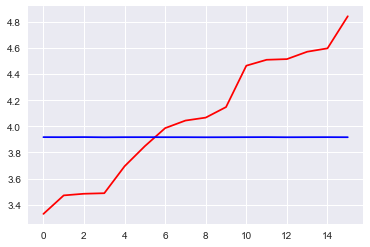

11810:0.8403833508491516	1.282723069190979
11820:0.6448270082473755	1.3082737922668457
11830:0.6858559846878052	1.2915594577789307
11840:0.8338106870651245	1.2924468517303467
11850:0.5367522239685059	1.3573288917541504
11860:0.8479054570198059	1.3420383930206299
11870:0.6776430606842041	1.3781402111053467
11880:0.8413633704185486	1.3501973152160645
11890:0.6099086403846741	1.3567726612091064
11900:0.85573410987854	1.3482955694198608


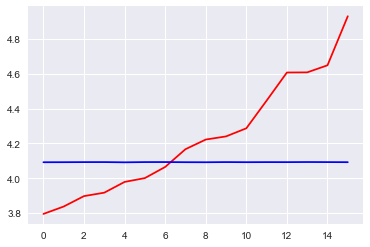

11910:0.5189640522003174	1.3385313749313354
11920:0.8017580509185791	1.3218392133712769
11930:0.6579098105430603	1.3137257099151611
11940:0.8533979654312134	1.310825228691101
11950:0.7388859987258911	1.319991946220398
11960:0.7687950134277344	1.3071873188018799
11970:0.7367717623710632	1.3199454545974731
11980:0.5330007672309875	1.3359498977661133
11990:0.628523051738739	1.3431769609451294


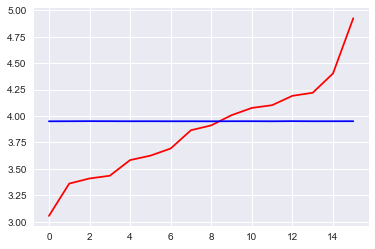

In [7]:
main()